**<h1> DOG VS CAT Classification Task using CNN </h1>**

DOG vs CAT dataset is taken from kaggle for the course project.

DATASET TYPE : Image dataset

DATASET URL  : https://www.kaggle.com/c/dogs-vs-cats

TASK : binary Image Classification


In [2]:
!pip install jovian --upgrade --quiet

Datasets from Kaggle can be downloaded using opendatasets library provided by jovian.ai

In [4]:
!pip install opendatasets --upgrade --quiet

In [5]:
import opendatasets as od

In [6]:
od.download('https://www.kaggle.com/c/dogs-vs-cats')

  1%|▏         | 11.0M/812M [00:00<00:07, 109MB/s]

100%|██████████| 812M/812M [00:04<00:00, 199MB/s]

Dataset is downloaded as zip format .Extract the dog vs cat dataset.

In [7]:
import zipfile

with zipfile.ZipFile('/content/dogs-vs-cats/dogs-vs-cats.zip', 'r') as zip_ref:
    zip_ref.extractall('./dogs-vs-cats')

After extracting Dataset, train and test folder is found in zip format.Extract those folders 

In [8]:
import zipfile

with zipfile.ZipFile('/content/dogs-vs-cats/train.zip', 'r') as zip_ref:
    zip_ref.extractall(".")
with zipfile.ZipFile('/content/dogs-vs-cats/test1.zip', 'r') as zip_ref:
    zip_ref.extractall(".")


Importing necessary package from pytorch 

In [116]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as tt
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
%matplotlib inline

<h2> Introduction </h2>

The goal of this notebook is to classify an image into 2 categories using CNN
References:

The dataset is taken from kaggle and the number of training samples are 25,000
and the number of test samples are 12,500.

Most of the explanations are taken from the jovian.ai course.


This Notebook has five main parts:

* Data preparation
* Loading data to the device
* Model creation .
* Training Model and evaluating model
* Model prediction on test data
* Ideas to improve the model


# Data Preparation

Before proceeding , its better to analyse the dataset.The datset contains an images of dogs and cats taken from various backgrounds.Here is the sample images from the train dataset.


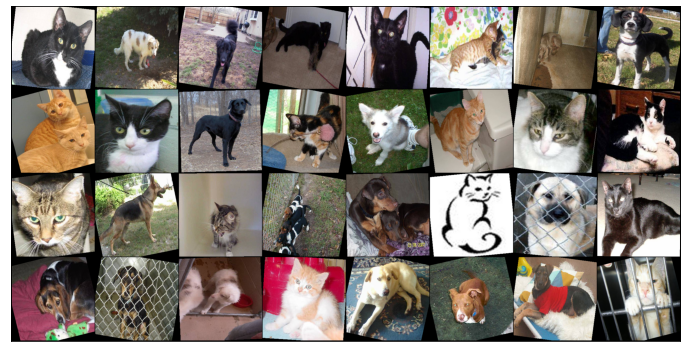

In [10]:
########defining train and test image directory
train_dir = "./train"
test_dir = "./test1"

Total Number of images in train and test dataset

In [11]:
all_train_images = os.listdir(train_dir)
len(all_train_images)

25000

In [12]:
all_test_images = os.listdir(test_dir)
len(all_test_images)

12500

Splitting the train dataset into train and validation set.Using validation set for evaluating hyperparameters.Here i choose test_size as 20%.we can choose test size from 10 to 30 %

In [13]:
train_dataset, val_dataset = train_test_split(all_train_images, test_size = 0.20,random_state=32)

In [14]:
len(train_dataset),len(val_dataset)

(20000, 5000)

Transform the images by applying below augmentations and convert it as Tensors

In [15]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(300, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         tt.RandomRotation(15),
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)
                         ])
valid_tfms = tt.Compose([tt.ToTensor(), 
                         tt.Normalize(*stats)
                         ])

In the dataset, label is not provided separately . Image name contains label as dogs and cats like below.

Here splitting image name using image.split with separator . it gives label as cat or dog .

'cat.7099.jpg',

 'dog.6142.jpg',

 'cat.2288.jpg',

 'dog.2512.jpg',

 'dog.9800.jpg'

 Assigned label 0 to dog and 1 to cat


In [51]:
def convert_label(label):
  target = torch.zeros(2)
  if label=="dog":
    target[0]=1
  else :
    target[1]=1
  return target

We can now create a custom dataset by extending the Dataset class from PyTorch. We need to define the __len__ and __getitem__ methods to create a dataset. We'll also provide the option of adding transforms into the constructor.

In [52]:
class DogCatDataset(Dataset):
    def __init__(self, image, root_dir,type_dataset,transform=None):
        self.image = image
        self.transform = transform
        self.root_dir = root_dir
        self.type_dataset = type_dataset
        
        
        
    def __len__(self):
        return len(self.image)    
    
    def __getitem__(self, idx):
        
        img_id = self.image[idx]
        img_fname = self.root_dir + "/" + str(img_id) 
        img = Image.open(img_fname)
        img = img.resize((300, 300))
        
        if self.transform:
            img = self.transform(img)
        if self.type_dataset == "train" or self.type_dataset == "val":
          img_label = convert_label(img_id.split(".")[0])
          return img,img_label
        else :  
          return img

Transforms can be chained using transforms.Compose. Here we are resizing the image to 300x300 before applying augmentations and convert it to tensors.

After converting an image to tensors, we are applying normalization.

In [53]:
train_ds = DogCatDataset(train_dataset,train_dir,"train",train_tfms)
val_ds = DogCatDataset(val_dataset,train_dir,"val",valid_tfms)
test_ds = DogCatDataset(all_test_images,test_dir,"test",valid_tfms)

Here is the sample tensors after applied transformations.label is present in each tensor as 1x2 tensor . index zero - 1 index one - 0 if the label is dog and index 0 -1 index 1 is 1 if the label is cat .(one hot encoding) 

In [54]:
train_ds[0]

(tensor([[[-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
          [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
          [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
          ...,
          [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
          [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
          [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291]],
 
         [[-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
          [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
          [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
          ...,
          [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
          [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
          [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183]],
 
         [[-2.2214, -2.2214, -2.2214,  ..., -2.2214, -2.2214, -2.2214],
          [-2.2214, -2.2214,

In [55]:
train_ds[15000]

(tensor([[[-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
          [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
          [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
          ...,
          [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
          [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
          [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291]],
 
         [[-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
          [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
          [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
          ...,
          [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
          [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
          [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183]],
 
         [[-2.2214, -2.2214, -2.2214,  ..., -2.2214, -2.2214, -2.2214],
          [-2.2214, -2.2214,

In [56]:
val_ds[10]

(tensor([[[0.4981, 0.4981, 0.5174,  ..., 1.3510, 1.3510, 1.3510],
          [0.4787, 0.4981, 0.5368,  ..., 1.3510, 1.3510, 1.3510],
          [0.4787, 0.4981, 0.5368,  ..., 1.3510, 1.3510, 1.3510],
          ...,
          [0.0328, 0.0134, 0.0134,  ..., 0.3430, 0.3624, 0.3430],
          [0.0134, 0.0328, 0.0328,  ..., 0.3430, 0.3430, 0.3430],
          [0.0134, 0.0328, 0.0328,  ..., 0.3430, 0.3430, 0.3430]],
 
         [[0.9448, 0.9448, 0.9644,  ..., 1.8495, 1.8495, 1.8495],
          [0.9251, 0.9448, 0.9841,  ..., 1.8495, 1.8495, 1.8495],
          [0.9251, 0.9448, 0.9841,  ..., 1.8495, 1.8495, 1.8495],
          ...,
          [0.2958, 0.2958, 0.2958,  ..., 0.6498, 0.6694, 0.6498],
          [0.2564, 0.2761, 0.2761,  ..., 0.6498, 0.6498, 0.6498],
          [0.2564, 0.2761, 0.2761,  ..., 0.6498, 0.6498, 0.6498]],
 
         [[1.2905, 1.2905, 1.3100,  ..., 2.2660, 2.2660, 2.2660],
          [1.2709, 1.2905, 1.3295,  ..., 2.2660, 2.2660, 2.2660],
          [1.2709, 1.2905, 1.3295,  ...,

In [57]:
test_ds[12]

tensor([[[ 0.5562,  0.4205,  0.5562,  ..., -0.4712, -0.4324, -0.5293],
         [ 0.5756,  0.1491,  0.4593,  ..., -0.5875, -0.5293, -0.5681],
         [ 1.0990,  0.8858,  1.1959,  ..., -0.6457, -0.6650, -0.7038],
         ...,
         [-2.1964, -2.2352, -2.0220,  ...,  0.5174,  0.6144,  0.5368],
         [-2.0608, -2.1189, -2.0414,  ...,  0.2073,  0.2654,  0.2461],
         [-2.0414, -2.0801, -2.0414,  ...,  0.1491,  0.2461,  0.2461]],

        [[ 0.2958,  0.1188,  0.1974,  ...,  0.2564,  0.3548,  0.2564],
         [ 0.2564, -0.2156,  0.0794,  ...,  0.1384,  0.2564,  0.2171],
         [ 0.7284,  0.4924,  0.7874,  ...,  0.1188,  0.1188,  0.0991],
         ...,
         [-1.9266, -2.0643, -2.0053,  ...,  0.2368,  0.2761,  0.1974],
         [-1.9659, -2.0446, -2.0053,  ...,  0.0204, -0.0189, -0.0386],
         [-2.0053, -2.0446, -1.9856,  ..., -0.0189, -0.0189, -0.0189]],

        [[ 0.1394,  0.0028,  0.0418,  ..., -0.0948, -0.3874, -0.5240],
         [ 0.1394, -0.3094, -0.0753,  ..., -0

In [58]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means
def show_image(dataset,index,stats="None"):
  image, label = dataset[index]
  
  if stats != "None":
    image = denormalize(image, *stats)
    image = image.reshape(3, 300,300)
  plt.imshow(image.permute(1,2,0))
  print('Label:', label)


Training sample before normalization 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: tensor([1., 0.])


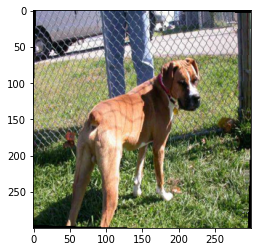

In [59]:
######
show_image(train_ds,0,stats)

Training image after normalization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: tensor([1., 0.])


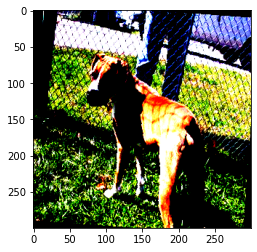

In [60]:
show_image(train_ds,0,"None")

Label: tensor([0., 1.])


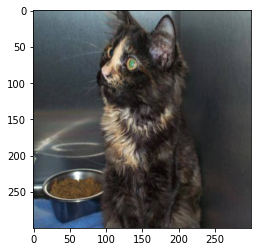

In [61]:
show_image(val_ds,0,stats)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: tensor([0., 1.])


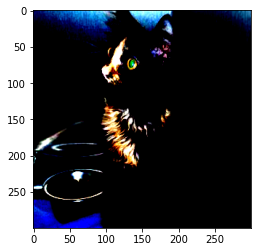

In [62]:
show_image(val_ds,0,"None")

Dog vs cat dataset is balanced dataset.The below module helps to view the number of images in each category

In [63]:
####Printing number of images in each category########
def number_of_img_in_category(dataset):
  class_dict = {}
  for i in range(0,len(dataset)):
    image,label = dataset[i]
    if label[0] == 1:
      label = 0
    else :
      label = 1
    
    if label in class_dict.keys():
      class_dict[label]=class_dict[label]+1
    else :
      class_dict[label]=1
  
  return class_dict

In [64]:
number_of_img_in_category(val_ds)

{0: 2548, 1: 2452}

In [30]:
number_of_img_in_category(train_ds)

{0: 9952, 1: 10048}

# Loading data to the device 

In [66]:
#defining batch size
batch_size=32

In [67]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=3, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers=3, pin_memory=True)

In [68]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

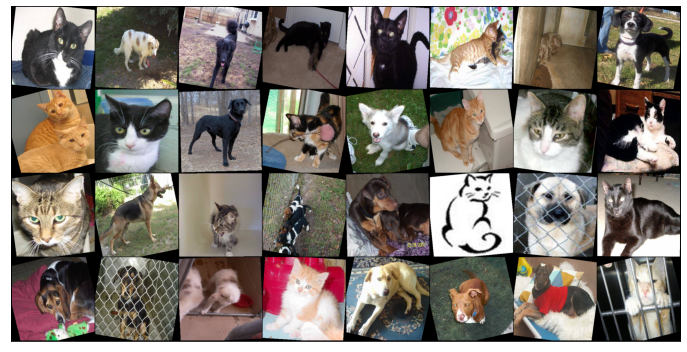

In [69]:
show_batch(train_dl)  ###viewing single batch of image

Utility functions to check the device type and move the data to the existing device

In [70]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [71]:
device = get_default_device()
device

device(type='cuda')

Move the data to the target device

In [138]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(val_dl, device)

Here i  used accuracy to measure the model performance.i used imageclassificationbase class from jovian.ai tutorial code

In [139]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    _,trues = torch.max(labels,dim=1)
    return torch.tensor(torch.sum(preds == trues).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.binary_cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.binary_cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
        
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
    
    

In [140]:
'''class CatDogModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            #32x300x300
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),

            nn.Flatten(), 
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2),
            nn.Sigmoid()
        )
        
    def forward(self, xb):
        return self.network(xb)'''

# Building Model using pre-trained model

Here we used pretrained resnet18 model for this task .Below is the architecture of the model.At the tail added linear layers to convert the output as required feature

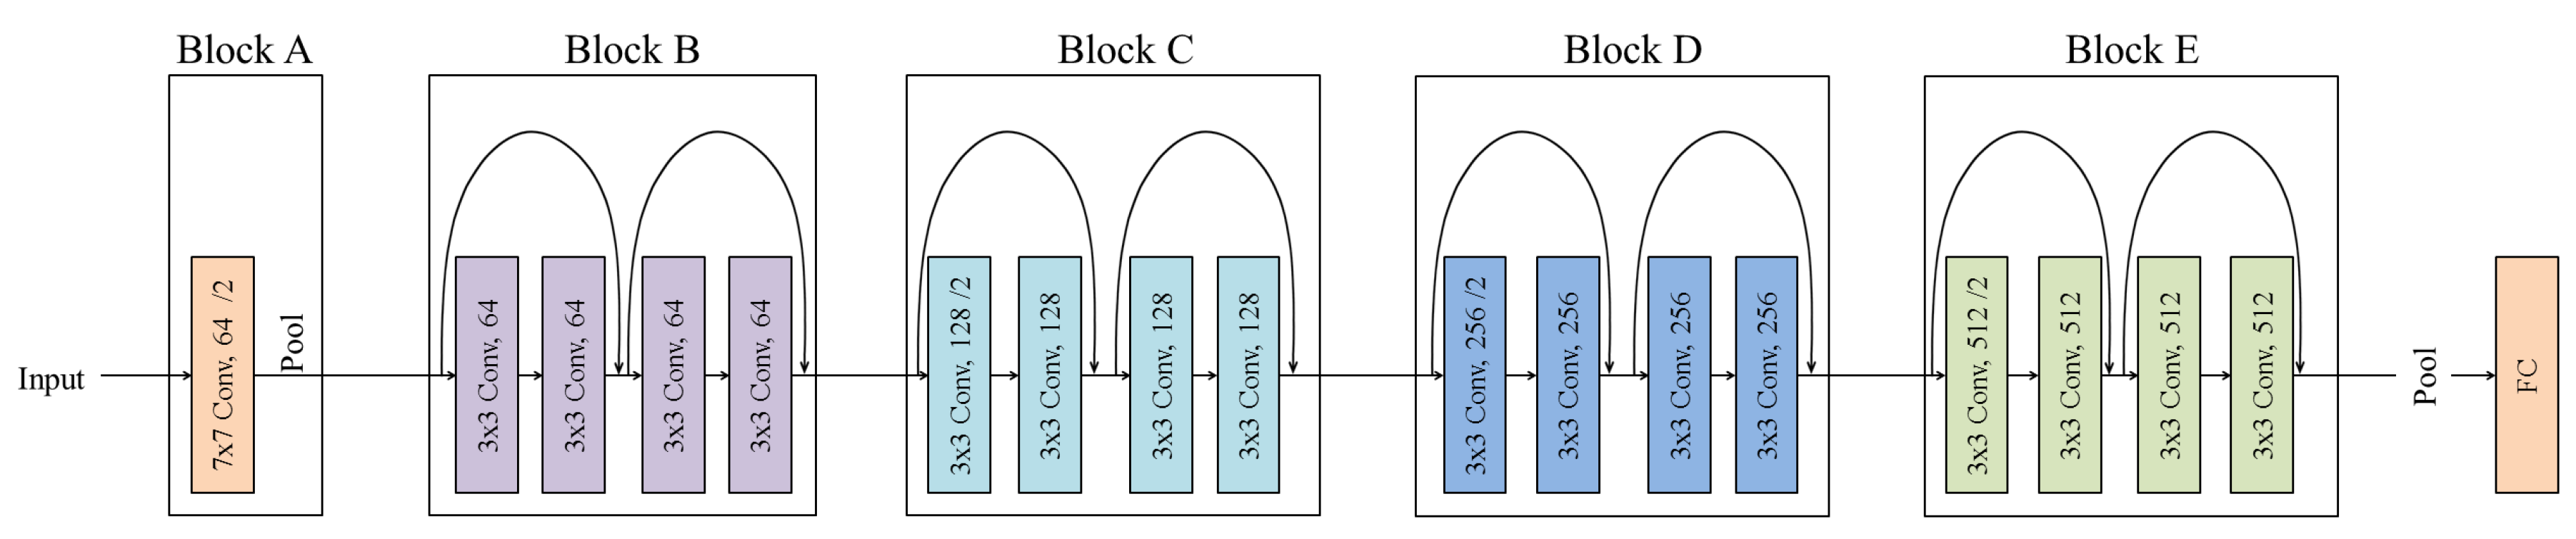

In [279]:
import torchvision.models as models
class CatDogModel(ImageClassificationBase):
  def __init__(self):
        super().__init__()
        self.network =models.resnet18(pretrained=True)
        self.network.fc = nn.Sequential(
        nn.Linear(512, 2, bias = True),
        nn.Sigmoid()
        )
  def forward(self, xb):
    return torch.sigmoid(self.network(xb))

In [280]:
#model = to_device(CatDogModel(), device)
model = to_device(CatDogModel(),device)
model

CatDogModel(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

It is always better to try the batch size first to know whether the cuda memory can accomodate the specified batch size

In [274]:
def try_batch(dl):
    for images, labels in dl:
        print('images.shape:', images.shape)
        out = model(images)
        print('out.shape:', out.shape)
        print('out[0]:', out[0])
        
        break

try_batch(train_dl)

images.shape: torch.Size([32, 3, 300, 300])
out.shape: torch.Size([32, 2])
out[0]: tensor([0.6231, 0.5545], device='cuda:0', grad_fn=<SelectBackward>)


In [275]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lrs, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), lrs)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        
        result['train_loss'] = torch.stack(train_losses).mean().item()
       # print(result)
        model.epoch_end(epoch, result)
        
        history.append(result)
    return history

# Training model and evaluating model parameters

In [276]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.5059335231781006, 'val_loss': 0.7293620109558105}]

In [282]:
num_epochs = 10
opt_func = torch.optim.Adam
lrs = 0.001

In [283]:
%%time
history = fit(num_epochs, lrs, model, train_dl, valid_dl, opt_func)


Epoch [0], train_loss: 0.5489, val_loss: 0.5799, val_score: 0.8408



Epoch [1], train_loss: 0.5370, val_loss: 0.5273, val_score: 0.9506



Epoch [2], train_loss: 0.5332, val_loss: 0.5323, val_score: 0.9395



Epoch [3], train_loss: 0.5273, val_loss: 0.5420, val_score: 0.9173



Epoch [4], train_loss: 0.5275, val_loss: 0.5327, val_score: 0.9403



Epoch [5], train_loss: 0.5269, val_loss: 0.5457, val_score: 0.9098



Epoch [6], train_loss: 0.5277, val_loss: 0.5268, val_score: 0.9519



Epoch [7], train_loss: 0.5241, val_loss: 0.5195, val_score: 0.9664



Epoch [8], train_loss: 0.5222, val_loss: 0.5255, val_score: 0.9537



Epoch [9], train_loss: 0.5240, val_loss: 0.5201, val_score: 0.9664
CPU times: user 6min 27s, sys: 3min 17s, total: 9min 45s
Wall time: 30min 27s


In [263]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

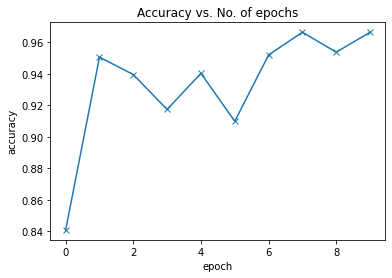

In [292]:
plot_accuracies(history)

In [293]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

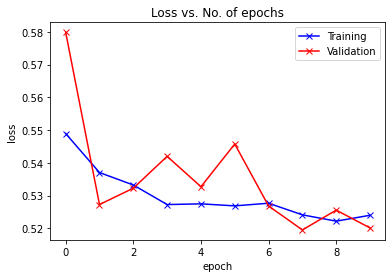

In [294]:
plot_losses(history)

Recording parameters

In [295]:
arch = "Resnet18"
lrs = 0.001
train_loss= 0.5240
val_loss= 0.5201
val_score= 0.9664
torch.save(model.state_dict(), 'resnet18-10-feedforward.pth')


In [289]:
jovian.reset()

In [290]:
jovian.log_hyperparams(arch=arch, 
                       lrs=lrs, 
                       train_loss=train_loss,
                       val_loss = val_loss,
                       val_score = val_score,

                       epochs=num_epochs)


[jovian] Hyperparams logged.


# Predicting Test data

In [191]:
@torch.no_grad()
def predict_dl(dl, model):
    torch.cuda.empty_cache()
    batch_probs = []
    for xb in tqdm(dl):
        probs = model(xb)
        batch_probs.append(probs.cpu().detach())
    batch_probs = torch.cat(batch_probs)
    return batch_probs

In [193]:
test_dl = DeviceDataLoader(test_dl, device)

In [194]:
test_preds = predict_dl(test_dl, model)
test_preds

tensor([[0.5000, 0.7311],
        [0.5000, 0.7311],
        [0.7311, 0.5000],
        ...,
        [0.5000, 0.7311],
        [0.7311, 0.5000],
        [0.7311, 0.5000]])

In [199]:
_,test_prediction = torch.max(test_preds,1)
test_prediction[0:5]


tensor([1, 1, 0, 1, 1])

In [200]:
len(test_prediction)

12500

Dog vs cat classification task is old task and it wont accept any submissions.but we have alternate ways to evaluate the model

In [204]:
TEST_CSV = '/content/dogs-vs-cats/sampleSubmission.csv'
submission_df = pd.read_csv(TEST_CSV)
submission_df.label = test_prediction
submission_df.head()

id  label
0   1      1
1   2      1
2   3      0
3   4      1
4   5      1

In [205]:
sub_fname = 'dogcatclassification_submission.csv'

In [206]:
submission_df.to_csv(sub_fname, index=False)

Url to submit : https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/overview/evaluation

Here they are accepting late submissions but here the evaluation is based on the probability score . in label column , we need to specify the dog's probabilty score instead of label

In [220]:
test_preds

tensor([[0.5000, 0.7311],
        [0.5000, 0.7311],
        [0.7311, 0.5000],
        ...,
        [0.5000, 0.7311],
        [0.7311, 0.5000],
        [0.7311, 0.5000]])

In [224]:

test_prob = test_preds[0:len(test_preds),0].clone()

In [225]:
TEST_CSV = '/content/dogs-vs-cats/sampleSubmission.csv'
submission_df_1 = pd.read_csv(TEST_CSV)

submission_df_1.label = test_prob
submission_df_1.head()

id     label
0   1  0.500000
1   2  0.500000
2   3  0.731059
3   4  0.500000
4   5  0.500000

In [226]:
sub_fname_1 = 'dogprob_submission.csv'

in this csv file , we are writing the dog's probabilty score and submit in kaggle.

In [227]:
submission_df_1.to_csv(sub_fname_1, index=False)

**<h2> Conclusion</h2>**

Here we used the pretrained resnet18 for this project .we achieved validation accuracy for about 95%.

**<h2> Future Work : </h2>**


* Try applying various transformations and pick the best one suited for this model.
* Try to evaluate with different hyperparameters 
* Use the other pretrained models and compare its accuracies .pick the best model based on the metrics.
* Defining own architecture from the insights get from pretrained model and verify whether its working fine

In [296]:
project_name='Dog-Vs-Cat Classification'
jovian.commit(project=project_name,outputs=["resnet18-10-feedforward.pth"],environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/isantha96/dog-vs-cat-classification


'https://jovian.ai/isantha96/dog-vs-cat-classification'